# Imports

In [1]:
import sys
sys.path.append('../')

In [2]:
import os
from PIL import Image

In [16]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision as tv

import numpy as np
import imgaug.augmentables as ia
import imgaug.augmenters as iaa
from numpy import linalg as la
import shapely.affinity as aff
import shapely.geometry as geo
from skimage.draw import polygon

import matplotlib.pyplot as plt

In [4]:
from src.modeling_efficientdet import EfficientDetDoesEAST
from src.east_utils import scale_box, create_ground_truth

In [5]:
coef = 2
coef2size = {
    0: 512,
    1: 640,
    2: 768,
    3: 896,
    4: 1024,
    5: 1280,
    6: 1280,
    7: 1536
}
size = coef2size[coef]
height = size
width = height // 2

In [6]:
scale = 4

# Dataset

In [17]:
folderpath = '../../sroie/SROIE2019/0325updated.task1train(626p)/'
image_files = [f for f in os.listdir(folderpath) if f.endswith('.jpg')]
text_files  = [f for f in os.listdir(folderpath) if f.endswith('.txt')]
image_files.sort()

In [10]:
def get_image(image_path):
    pil_image = Image.open(image_path)
    np_image = np.array(pil_image)
    return np_image

def get_bboxes(annotations_path, shape):
    txt_annotations = open(annotations_path).read().split('\n')
    boxes = []
    for row in txt_annotations[:-1]:
        x0, y0, _, _, x2, y2, _, _, _ = row.split(',', 8)
        boxes.append(ia.BoundingBox(int(x0), int(y0), int(x2), int(y2)))
    boxes_on_image = ia.BoundingBoxesOnImage(boxes, shape=shape)
    return boxes_on_image

def get_image_and_bboxes(image_path):
    annotations_path = image_path.replace('.jpg', '.txt')
    image = get_image(image_path)
    bboxes = get_bboxes(annotations_path, shape=image.shape)
    return image, bboxes

def resizer(image=None, bboxes=None, size=(512, 512)):
    kwargs = {}
    if image is not None:
        kwargs['image'] = image
    if bboxes is not None:
        kwargs['bounding_boxes'] = bboxes
    assert len(kwargs), 'Needs image or bboxes to resize'
    return iaa.Resize({'width':size[1], 'height': size[0]})(**kwargs)

def get_input_image_and_bboxes(image, bboxes, image_size, scale):
    h, w = image_size
    mh, mw = h // scale, w // scale
    image = resizer(image=image, size=(h, w))
    bboxes = resizer(bboxes=bboxes, size=(mh, mw))
    return image, bboxes

def scale_bboxes(bboxes, pct=0.7, minh=2, minw=4):
    # original without removed pixels
    boxes = bboxes.to_xyxy_array(np.int32)
    # remove pixels from boxes
    mask_boxes = np.array([scale_box(box, pct=pct, minh=minh, minw=minw) for box in boxes])
    return boxes, mask_boxes

In [27]:
class SROIEDataset(Dataset):
    
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    
    def __init__(self, image_files, folderpath, height, width, scale, tfms_list=[]):
        self.image_files = image_files
        self.folderpath = folderpath
        self.height = height
        self.width = width
        self.scale = scale
        
        self.tfms = tv.transforms.Compose([
            tv.transforms.ToTensor(),
            tv.transforms.Normalize(mean=self.mean,std=self.std)
        ] + tfms_list)
    
    def __len__(self,):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.folderpath, self.image_files[idx])
        image, bboxes = get_image_and_bboxes(image_path)
        
        size = (self.height, self.width)

        image, bboxes = get_input_image_and_bboxes(image, bboxes, image_size=size, scale=self.scale)
        boxes, mask_boxes = scale_bboxes(bboxes, pct=0.7)
        gt_image, loss_mask = create_ground_truth(boxes, mask_boxes, size, scale)
        
        return self.tfms(image), gt_image

In [28]:
image, bboxes = get_image_and_bboxes(os.path.join(folderpath, image_files[0]))

In [29]:
image, bboxes = get_input_image_and_bboxes(image, bboxes, image_size=(height, width), scale=scale)

In [30]:
boxes, mask_boxes = scale_bboxes(bboxes, pct=0.7)

In [31]:
gt_image, loss_mask = create_ground_truth(boxes, mask_boxes, (height, width), scale)

In [32]:
image.shape, gt_image.shape, loss_mask.shape

((768, 384, 3), (5, 192, 96), (192, 96))

In [33]:
ds_debug = SROIEDataset(image_files, folderpath, height, width, scale)

In [34]:
image, gt_image = ds_debug[0]
image.shape, gt_image.shape

(torch.Size([3, 768, 384]), (5, 192, 96))

In [59]:
dl_debug = DataLoader(ds_debug, batch_size=8, shuffle=False)
x, y = next(iter(dl_debug))
x.shape, y.shape

(torch.Size([8, 3, 768, 384]), torch.Size([8, 5, 192, 96]))

In [60]:
grid = tv.utils.make_grid(x)
grid = grid.permute(1,2,0) * ds_debug.std + ds_debug.mean

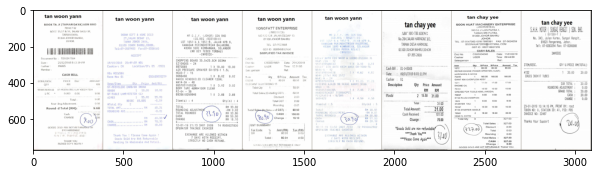

In [61]:
plt.figure(figsize=(10,10))
plt.imshow(grid)